# League of Legends Match Predictor

Project for IBM AI Engineering certification course.

## Modules

In [1]:
!pip install pandas scikit-learn matplotlib torch torchvision torchaudio -q

In [2]:
from google.colab import userdata
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch import nn
from torch import optim
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, confusion_matrix, classification_report

## Dataset

In [3]:
df = pd.read_csv(userdata.get('LOL_DATA_URL'))

print(df.shape)
display(df.head())

(1000, 9)


,win,kills,deaths,assists,gold_earned,cs,wards_placed,wards_killed,damage_dealt
0,0,16,6,19,17088,231,11,7,15367
1,1,8,8,5,14865,259,10,2,38332
2,0,0,17,11,15919,169,14,5,24642
3,0,19,11,1,11534,264,14,3,15789
4,0,12,7,6,18926,124,15,7,40268


In [4]:
print(df['win'].value_counts())

win
1    510
0    490
Name: count, dtype: int64


In [5]:
X = df.drop(columns=['win'])
y = df.win

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()

X_train = torch.tensor(scaler.fit_transform(X_train), dtype=torch.float32)
X_test = torch.tensor(scaler.transform(X_test), dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

print('X train size:', X_train.shape[0])
print('X test size:', X_test.shape[0])

X train size: 800
X test size: 200


## Model

### Base Model

In [6]:
class LR(nn.Module):
  def __init__(self, input_s, output_s):
    super(LR, self).__init__()
    self.l = nn.Linear(input_s, output_s)
    self.sig = nn.Sigmoid()

  def forward(self, X):
    return self.sig(self.l(X))

model = LR(X_train.shape[1], 1)
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

In [7]:
epochs = 1000

for epoch in range(epochs):
  model.train()

  optimizer.zero_grad()
  yhat = model(X_train)
  loss = criterion(yhat, y_train.view(-1, 1))
  loss.backward()
  optimizer.step()

  if epoch%100==0:
    print(f'[{epoch+1}/{epochs}] Loss = {loss}')

model.eval()
with torch.no_grad():
  yhat = model(X_test)
  preds = yhat > 0.5

  acc = (preds == y_test.view(-1, 1)).float().mean()
  print(f'Accuracy: {acc.item()}')

[1/1000] Loss = 0.7595951557159424
[101/1000] Loss = 0.733421266078949
[201/1000] Loss = 0.7166138291358948
[301/1000] Loss = 0.7061628699302673
[401/1000] Loss = 0.6997978687286377
[501/1000] Loss = 0.6959685683250427
[601/1000] Loss = 0.6936797499656677
[701/1000] Loss = 0.6923158168792725
[801/1000] Loss = 0.6915038228034973
[901/1000] Loss = 0.6910203695297241
Accuracy: 0.5649999976158142


### L2 Regularization

In [8]:
model = LR(X_train.shape[1], 1)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01)

epochs = 1000

for epoch in range(epochs):
  model.train()

  optimizer.zero_grad()
  yhat = model(X_train)
  loss = criterion(yhat, y_train.view(-1, 1))
  loss.backward()
  optimizer.step()

  if epoch%100==0:
    print(f'[{epoch+1}/{epochs}] Loss = {loss}')

[1/1000] Loss = 0.72783362865448
[101/1000] Loss = 0.7131471037864685
[201/1000] Loss = 0.7040290236473083
[301/1000] Loss = 0.6984851956367493
[401/1000] Loss = 0.6951584815979004
[501/1000] Loss = 0.6931776404380798
[601/1000] Loss = 0.6920033097267151
[701/1000] Loss = 0.6913084387779236
[801/1000] Loss = 0.6908978223800659
[901/1000] Loss = 0.6906552314758301


Accuracy: 0.5375000238418579


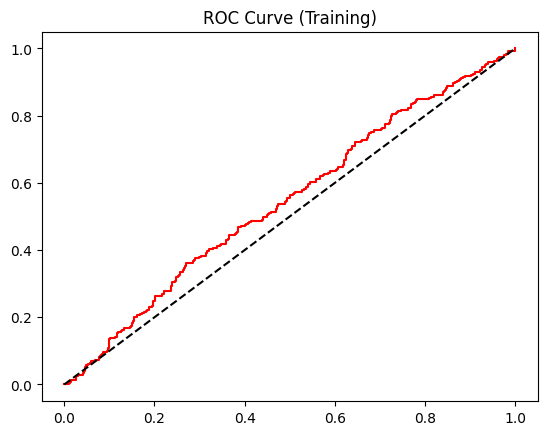

Confusion matrix:
[[145 123]
 [247 285]]

              precision    recall  f1-score   support

       False       0.37      0.54      0.44       268
        True       0.70      0.54      0.61       532

    accuracy                           0.54       800
   macro avg       0.53      0.54      0.52       800
weighted avg       0.59      0.54      0.55       800



In [9]:
model.eval()
with torch.no_grad():
  yhat = model(X_train)
  preds = yhat > 0.5

  acc = (preds == y_train.view(-1, 1)).float().mean()
  print(f'Accuracy: {acc.item()}')
  fpr, tpr, _ = roc_curve(y_train, yhat)
  plt.plot(fpr,tpr, 'r')
  plt.plot([0, 1], [0, 1], 'k--')
  plt.title('ROC Curve (Training)')
  plt.show()

  print('Confusion matrix:')
  print(confusion_matrix(preds, y_train.view(-1, 1)))
  print()
  print(classification_report(preds, y_train.view(-1, 1)))

In [10]:
torch.save(model.state_dict(), 'model_L2.pth')

In [11]:
model = LR(X_train.shape[1], 1)
model.load_state_dict(torch.load('model_L2.pth'))

<All keys matched successfully>

Accuracy: 0.5400000214576721


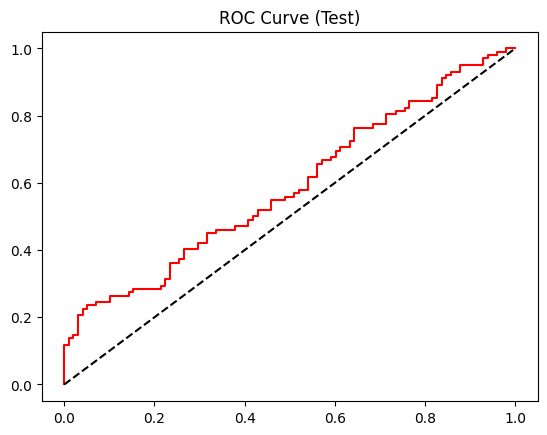

Confusion matrix:
[[39 33]
 [59 69]]

              precision    recall  f1-score   support

       False       0.40      0.54      0.46        72
        True       0.68      0.54      0.60       128

    accuracy                           0.54       200
   macro avg       0.54      0.54      0.53       200
weighted avg       0.58      0.54      0.55       200



In [12]:
model.eval()
with torch.no_grad():
  yhat = model(X_test)
  preds = yhat > 0.5

  acc = (preds == y_test.view(-1, 1)).float().mean()
  print(f'Accuracy: {acc.item()}')

  fpr, tpr, _ = roc_curve(y_test, yhat)
  plt.plot(fpr,tpr, 'r')
  plt.plot([0, 1], [0, 1], 'k--')
  plt.title('ROC Curve (Test)')
  plt.show()

  print('Confusion matrix:')
  print(confusion_matrix(preds, y_test.view(-1, 1)))
  print()
  print(classification_report(preds, y_test.view(-1, 1)))

### Optimization

In [13]:
learnig_rates = [0.01, 0.05, 0.1]
epoches = 1000

models = []

for lr in learnig_rates:
  print('Training lr:', lr)
  model = LR(X_train.shape[1], 1)
  optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01)
  for epoch in range(epochs):
    model.train()

    optimizer.zero_grad()
    yhat = model(X_train)
    loss = criterion(yhat, y_train.view(-1, 1))
    loss.backward()
    optimizer.step()

    if epoch%100==0:
      print(f'[{epoch+1}/{epochs}] Loss = {loss}')

  model.eval()
  with torch.no_grad():
    yhat = model(X_test)
    preds = yhat > 0.5

    acc = (preds == y_test.view(-1, 1)).float().mean()
    print(f'Accuracy: {acc.item()}')
  models.append(model)
  print('='*20,'\n')

Training lr: 0.01
[1/1000] Loss = 0.7308536767959595
[101/1000] Loss = 0.7146451473236084
[201/1000] Loss = 0.7047663927078247
[301/1000] Loss = 0.6988589763641357
[401/1000] Loss = 0.6953617334365845
[501/1000] Loss = 0.6933000683784485
[601/1000] Loss = 0.6920856237411499
[701/1000] Loss = 0.6913691163063049
[801/1000] Loss = 0.6909452080726624
[901/1000] Loss = 0.690693199634552
Accuracy: 0.5400000214576721

Training lr: 0.05
[1/1000] Loss = 0.7279905676841736
[101/1000] Loss = 0.7137151956558228
[201/1000] Loss = 0.7046701908111572
[301/1000] Loss = 0.6990517973899841
[401/1000] Loss = 0.6956067085266113
[501/1000] Loss = 0.6935107707977295
[601/1000] Loss = 0.692241370677948
[701/1000] Loss = 0.6914745569229126
[801/1000] Loss = 0.6910116076469421
[901/1000] Loss = 0.6907323598861694
Accuracy: 0.5450000166893005

Training lr: 0.1
[1/1000] Loss = 0.7570550441741943
[101/1000] Loss = 0.7312706112861633
[201/1000] Loss = 0.7149704098701477
[301/1000] Loss = 0.704986572265625
[401/100

### Feature importance

<Axes: ylabel='name'>

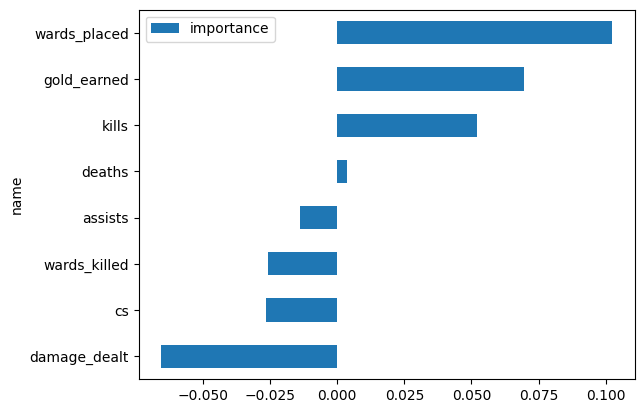

In [14]:
feature_importance = pd.DataFrame({
    'name':X.columns,
    'importance':models[1].l.weight.data.numpy().flatten(),
}).sort_values('importance')

feature_importance.plot.barh(y='importance', x='name')